In [36]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis_work/ML_experiments'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/16LLv0tl9NuELAOpNIA0EW8v8njV1fcVa/Thesis_work/ML_experiments


#Loading libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
#!pip install xgboost
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostRegressor
import sklearn
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

#Method for confusion matrix plot

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(Y, predicted):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))

  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(Y, Y_predicted_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(Y, Y_predicted_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(Y, Y_predicted_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(Y, Y_predicted_classes)
  print('F1 score: %f' % f1)
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#Load the dataset


In [39]:
data = pd.read_csv('final_dataset_reviews_clean.csv')
# data.drop(columns=['Unnamed: 0'], inplace = True)
data.head(2)

,Product_ID,Customer_Name,Customer_ID,Date,Rating,Label,Reviews,Sentiment,Features,length,...,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score,Reviews_clean,Sentiment_class,length_clean,words_clean,pid_encoded
0,TE111EL1,itzmr7,6702,2019-11-09,1,0,mil gya hai acha hai aur toota howa b nai hai,Positive,['toota'],45,...,0.051918,0,1,-2.000000,-2.000000,acha tota howa nahi,1.0,19,4,539
1,MI543EL0,Afridi,396,2016-11-21,5,0,aram sy pocket may aa jta hai aur quality b ac...,Positive,"['aram', 'pocket', 'quality']",52,...,0.035987,1,1,0.466667,0.466667,aram pocket jta quality achi,1.0,28,5,336


In [40]:
data['Label'].value_counts()

0    3393
1     530
Name: Label, dtype: int64

#Features and label

In [41]:
X=data.drop(columns=['Label','Sentiment','Date', 'Reviews', 'Reviews_clean', 'Features', 'Product_ID',	'Customer_Name'], axis =1, inplace=False)
y=data['Label']

In [42]:
X.shape

(3923, 15)

#Textual Feature Extraction from dataset

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=1, stop_words="english")

tfidf = vect.fit_transform(data['Reviews_clean'])

In [44]:
tfidf[1]

<1x6370 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [45]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
max_len = 80
max_words = 2000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(data['Reviews_clean'])
sequences = tok.texts_to_sequences(data['Reviews_clean'])
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [46]:
X.columns

Index(['Customer_ID', 'Rating', 'length', 'Activity_window', 'words_counts',
       'pp1', 'content_similarity', 'ext_score', 'IRS_score', 'ARD_Score',
       'RD_Score', 'Sentiment_class', 'length_clean', 'words_clean',
       'pid_encoded'],
      dtype='object')

#Fusion of textual and behavioral features

In [47]:
Test_features_with_linguestics = sequences_matrix.tolist()

count =0
for words_counts,pp1,content_similarity,ext_score,IRS_score,ARD_Score,RD_Score, id, pid, window, len, rating, sent, lenc  in zip(
    X['words_counts'],
    X['pp1'],
    X['content_similarity'],
    X['ext_score'],
    X['IRS_score'],
    X['ARD_Score'],
    X['RD_Score'],
    X['Customer_ID'],
    X['pid_encoded'],
    X['Activity_window'],
    X['length'],
    X['Rating'],
    X['Sentiment_class'],
    X['length_clean']
    ):
    Test_features_with_linguestics[count].append(abs(words_counts))
    Test_features_with_linguestics[count].append(abs(pp1))
    Test_features_with_linguestics[count].append(abs(content_similarity))
    Test_features_with_linguestics[count].append(abs(ext_score))
    Test_features_with_linguestics[count].append(abs(IRS_score))
    Test_features_with_linguestics[count].append(abs(ARD_Score))
    Test_features_with_linguestics[count].append(abs(RD_Score))
    Test_features_with_linguestics[count].append(abs(words_counts))
    Test_features_with_linguestics[count].append(abs(id))
    Test_features_with_linguestics[count].append(abs(pid))
    Test_features_with_linguestics[count].append(abs(window))
    Test_features_with_linguestics[count].append(abs(len))
    Test_features_with_linguestics[count].append(abs(rating))
    Test_features_with_linguestics[count].append(abs(sent))
    Test_features_with_linguestics[count].append(abs(lenc))



    count=count+1
Test_features_with_linguestics = np.asarray(Test_features_with_linguestics)
Test_features_with_linguestics[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

#TRain and test data

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Test_features_with_linguestics, y, stratify=y, test_size=0.1, random_state=42)

In [49]:
X_train.shape

(3530, 95)

In [50]:
X_train_ru = X_train
y_train_ru=y_train

In [51]:
X_train_ru.shape

(3530, 95)

In [52]:
X_test.shape

(393, 95)

#Basic Classification Models

##XGBoost

Accuracy: 0.905852
Precision: 0.807692
Recall: 0.396226
F1 score: 0.531646
(2, 2)
(2, 2)


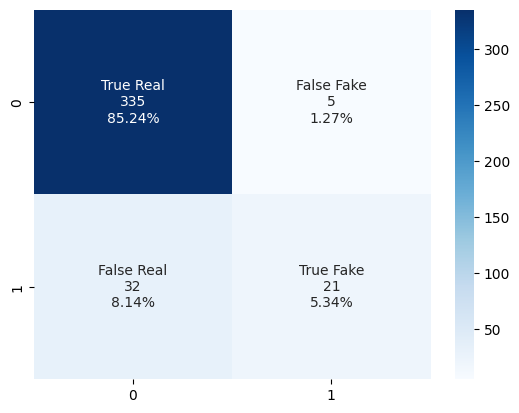

In [53]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
# fit model training data
model = XGBClassifier()

model.fit(X_train_ru, y_train_ru)

#---Without feature selection and parameter tuning------
pred_xg = model.predict(X_test)
# evaluate predictions
plot_confusion_matrix(y_test,pred_xg)


##**Gradient Boosting**

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       340
           1       0.81      0.25      0.38        53

    accuracy                           0.89       393
   macro avg       0.85      0.62      0.66       393
weighted avg       0.88      0.89      0.86       393

Accuracy: 0.890585
Precision: 0.812500
Recall: 0.245283
F1 score: 0.376812
(2, 2)
(2, 2)


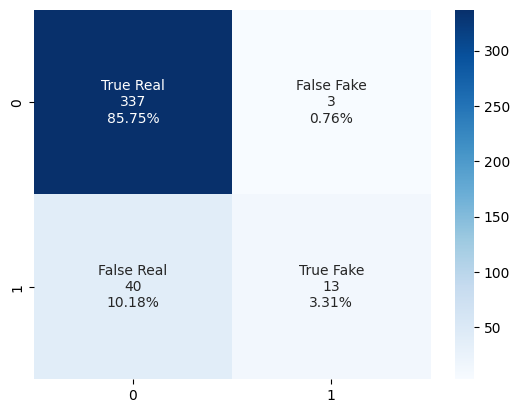

In [54]:
model_gb = GradientBoostingClassifier()

#-------- Without Feature selection---------
model_gb.fit(X_train_ru,y_train_ru)
pred_gb = model_gb.predict(X_test)
print(classification_report(y_test, pred_gb))

#-----evaluate results-----
plot_confusion_matrix(y_test,pred_gb)


##Light GBM

[LightGBM] [Info] Number of positive: 477, number of negative: 3053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9939
[LightGBM] [Info] Number of data points in the train set: 3530, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135127 -> initscore=-1.856364
[LightGBM] [Info] Start training from score -1.856364
Accuracy: 0.900763
Precision: 0.791667
Recall: 0.358491
F1 score: 0.493506
(2, 2)
(2, 2)


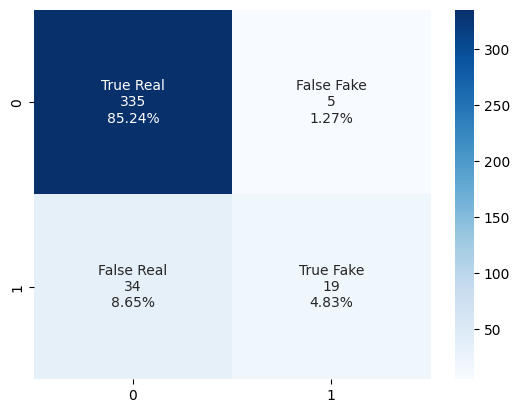

In [55]:
model_lg = lgb.LGBMClassifier()
model_lg.fit(X_train_ru, y_train_ru)
pred_lg = model_lg.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_lg)

##Decision Tree

Accuracy: 0.814249
Precision: 0.327586
Recall: 0.358491
F1 score: 0.342342
(2, 2)
(2, 2)


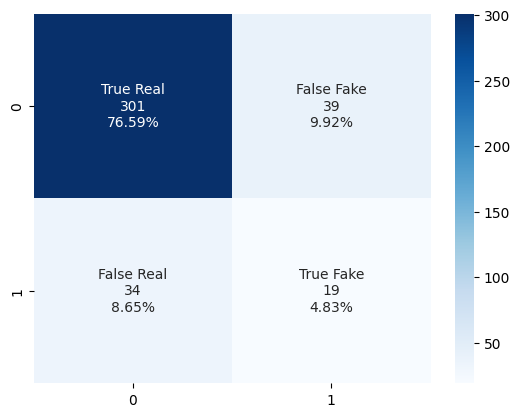

In [56]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_ru, y_train_ru)
pred_dt = model_dt.predict(X_test)
#print('accuracy %s' % accuracy_score(pred_lg, y_test))
#print(classification_report(y_test, pred_lg))
plot_confusion_matrix(y_test,pred_dt)

##Naive bayes

Accuracy: 0.753181
Precision: 0.250000
Recall: 0.415094
F1 score: 0.312057
(2, 2)
(2, 2)


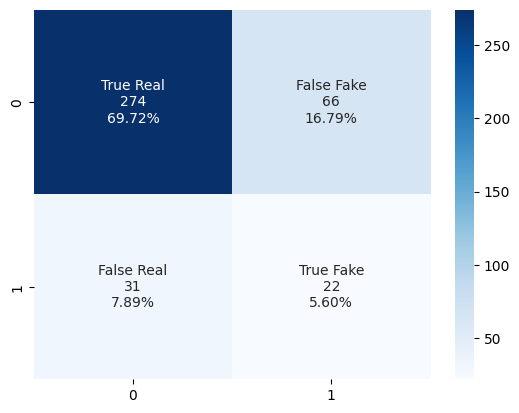

In [57]:
#Bernoulli Navie Bayes Classifier
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train_ru, y_train_ru)
pred_nb = BNB_Classifier.predict(X_test)
# print("\nClassification report for BernoulliNB Classifier %s:\n%s\n" % (BNB_Classifier, metrics.classification_report(y_test, pred_nb)))
plot_confusion_matrix(y_test,pred_nb)


Accuracy: 0.796438
Precision: 0.212766
Recall: 0.188679
F1 score: 0.200000
(2, 2)
(2, 2)


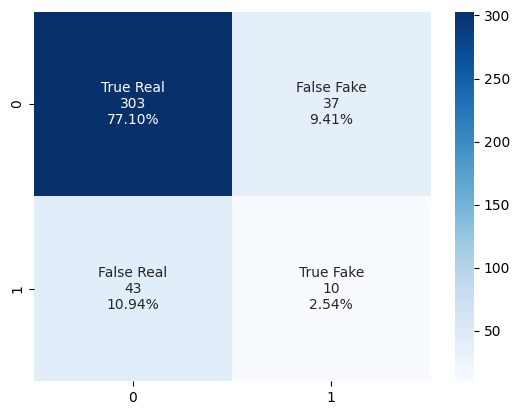

In [58]:
#Bernoulli Navie Bayes Classifier
GNB_Classifier = GaussianNB()
GNB_Classifier.fit(X_train_ru, y_train_ru)
GNB_Predictions =  GNB_Classifier.predict(X_test)
plot_confusion_matrix(y_test,GNB_Predictions)

##Logistic REgression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.857506
Precision: 0.200000
Recall: 0.018868
F1 score: 0.034483
(2, 2)
(2, 2)


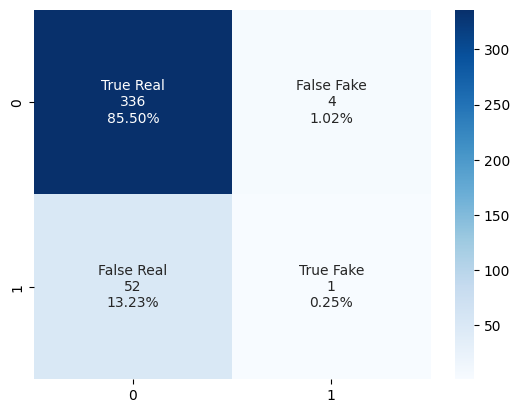

In [59]:
LR_Classifier = LogisticRegression()
LR_Classifier.fit(X_train_ru, y_train_ru)
pred_lr = LR_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_lr)

##Support VEctor

Accuracy: 0.865140
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
(2, 2)
(2, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


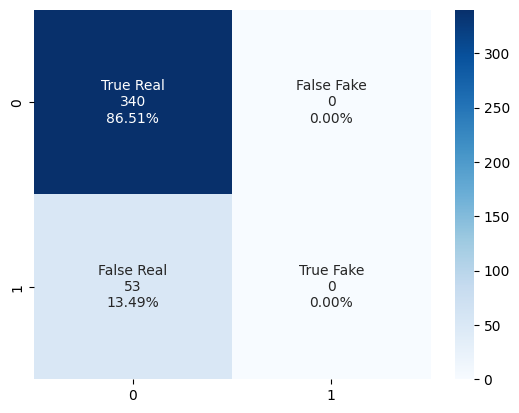

In [60]:
#SVC Classifier
SVC_Classifier = SVC()
SVC_Classifier.fit(X_train_ru, y_train_ru)
pred_svc = SVC_Classifier.predict(X_test)
plot_confusion_matrix(y_test,pred_svc)

##**Random Forest Classifier**

accuracy 0.8753180661577609
Accuracy: 0.875318
Precision: 1.000000
Recall: 0.075472
F1 score: 0.140351
(2, 2)
(2, 2)


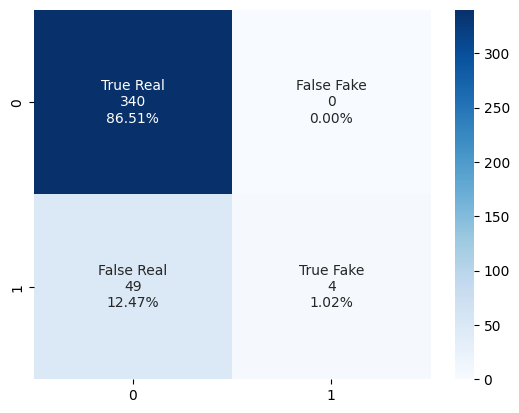

In [61]:

model_rf = RandomForestClassifier(n_estimators=110)
model_rf.fit(X_train_ru,y_train_ru)
pred_rf = model_rf.predict(X_test)
print('accuracy %s' % accuracy_score(pred_rf, y_test))
#print(classification_report(y_test, pred_rf))
plot_confusion_matrix(y_test,pred_rf)

##**Stochastic Gradient Descent**

Accuracy: 0.325700
Precision: 0.134483
Recall: 0.735849
F1 score: 0.227405
(2, 2)
(2, 2)


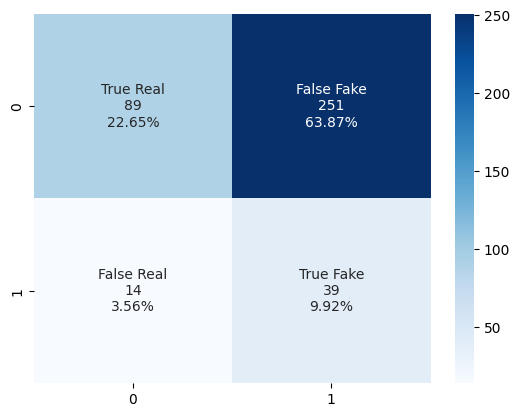

In [62]:

model_sg = SGDClassifier()
model_sg.fit(X_train_ru,y_train_ru)
pred_sg = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_sg)

##ANN

In [63]:
X_train_ru.shape[1]

95

In [64]:
from keras import models
from keras import layers
dnn = models.Sequential()
dnn.add(layers.Dense(16, activation = 'relu', input_shape=(X_train_ru.shape[1],)))
dnn.add(layers.Dropout(0.3))
dnn.add(layers.Dense(8, activation = 'relu', input_shape=(X_train_ru.shape[1],)))

dnn.add(layers.Dense(1, activation = 'sigmoid'))

dnn.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = dnn.fit(X_train_ru,
                  y_train_ru,
                    batch_size=40)

dnn.evaluate(X_test,y_test)

13/13 [==============================] - 0s 3ms/step - loss: 7.1256 - accuracy: 0.7023


[7.125590801239014, 0.7022900581359863]

Accuracy: 0.325700
Precision: 0.134483
Recall: 0.735849
F1 score: 0.227405
(2, 2)
(2, 2)


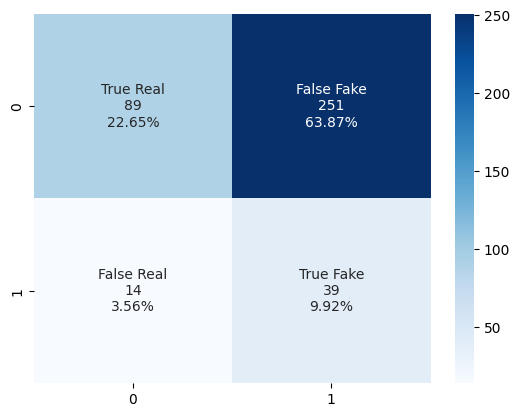

In [65]:
pred_ann = model_sg.predict(X_test)
plot_confusion_matrix(y_test,pred_ann)

#**Best model Accuracy and F-score**

We tested six different models and now, we check which one is the best:

In [66]:
xg_acc = accuracy_score(pred_xg, y_test)
gb_acc = accuracy_score(pred_gb, y_test)
nb_acc = accuracy_score(pred_nb, y_test)
rf_acc = accuracy_score(pred_rf, y_test)
sg_acc = accuracy_score(pred_sg, y_test)
svm_acc = accuracy_score(pred_svc, y_test)
lr_acc = accuracy_score(pred_lr, y_test)
dt_acc = accuracy_score(pred_dt, y_test)
ann_acc = accuracy_score(pred_ann, y_test)
lgb_acc = accuracy_score(pred_lg,y_test)

xg_f1 = f1_score(pred_xg, y_test)
gb_f1 = f1_score(pred_gb, y_test)
nb_f1 = f1_score(pred_nb, y_test)
rf_f1 = f1_score(pred_rf, y_test)
sg_f1 = f1_score(pred_sg, y_test)
svm_f1 = f1_score(pred_svc, y_test)
lr_f1 = f1_score(pred_lr, y_test)
dt_f1 = f1_score(pred_dt, y_test)
ann_f1 = f1_score(pred_ann, y_test)
lgb_f1 = f1_score(pred_lg,y_test)

In [67]:
models = pd.DataFrame({
                      'Model': ['Extreme Gradient','Light GBM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'Support Vector', 'stochastic gradient', 'Logistic Regression', 'Decision Tree', 'Neural Network'],
                      'Accuracy': [xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc],
                      'F-Score': [xg_f1, lgb_f1, nb_f1, rf_f1, gb_f1, svm_f1, sg_f1, lr_f1, dt_f1, ann_f1]
                       })
models.sort_values(by='F-Score', ascending=False, inplace=True)


In [68]:
models

,Model,Accuracy,F-Score
0,Extreme Gradient,0.905852,0.531646
1,Light GBM,0.900763,0.493506
4,Gradient Boosting,0.890585,0.376812
8,Decision Tree,0.814249,0.342342
2,Naive Bayes,0.753181,0.312057
6,stochastic gradient,0.325700,0.227405
9,Neural Network,0.325700,0.227405
3,Random Forest,0.875318,0.140351
7,Logistic Regression,0.857506,0.034483
5,Support Vector,0.865140,0.000000


##save results

In [69]:
models.to_csv("paper/expsettingI_ML_updated90.csv", index=False)

#Grouped confusion matrix

(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)


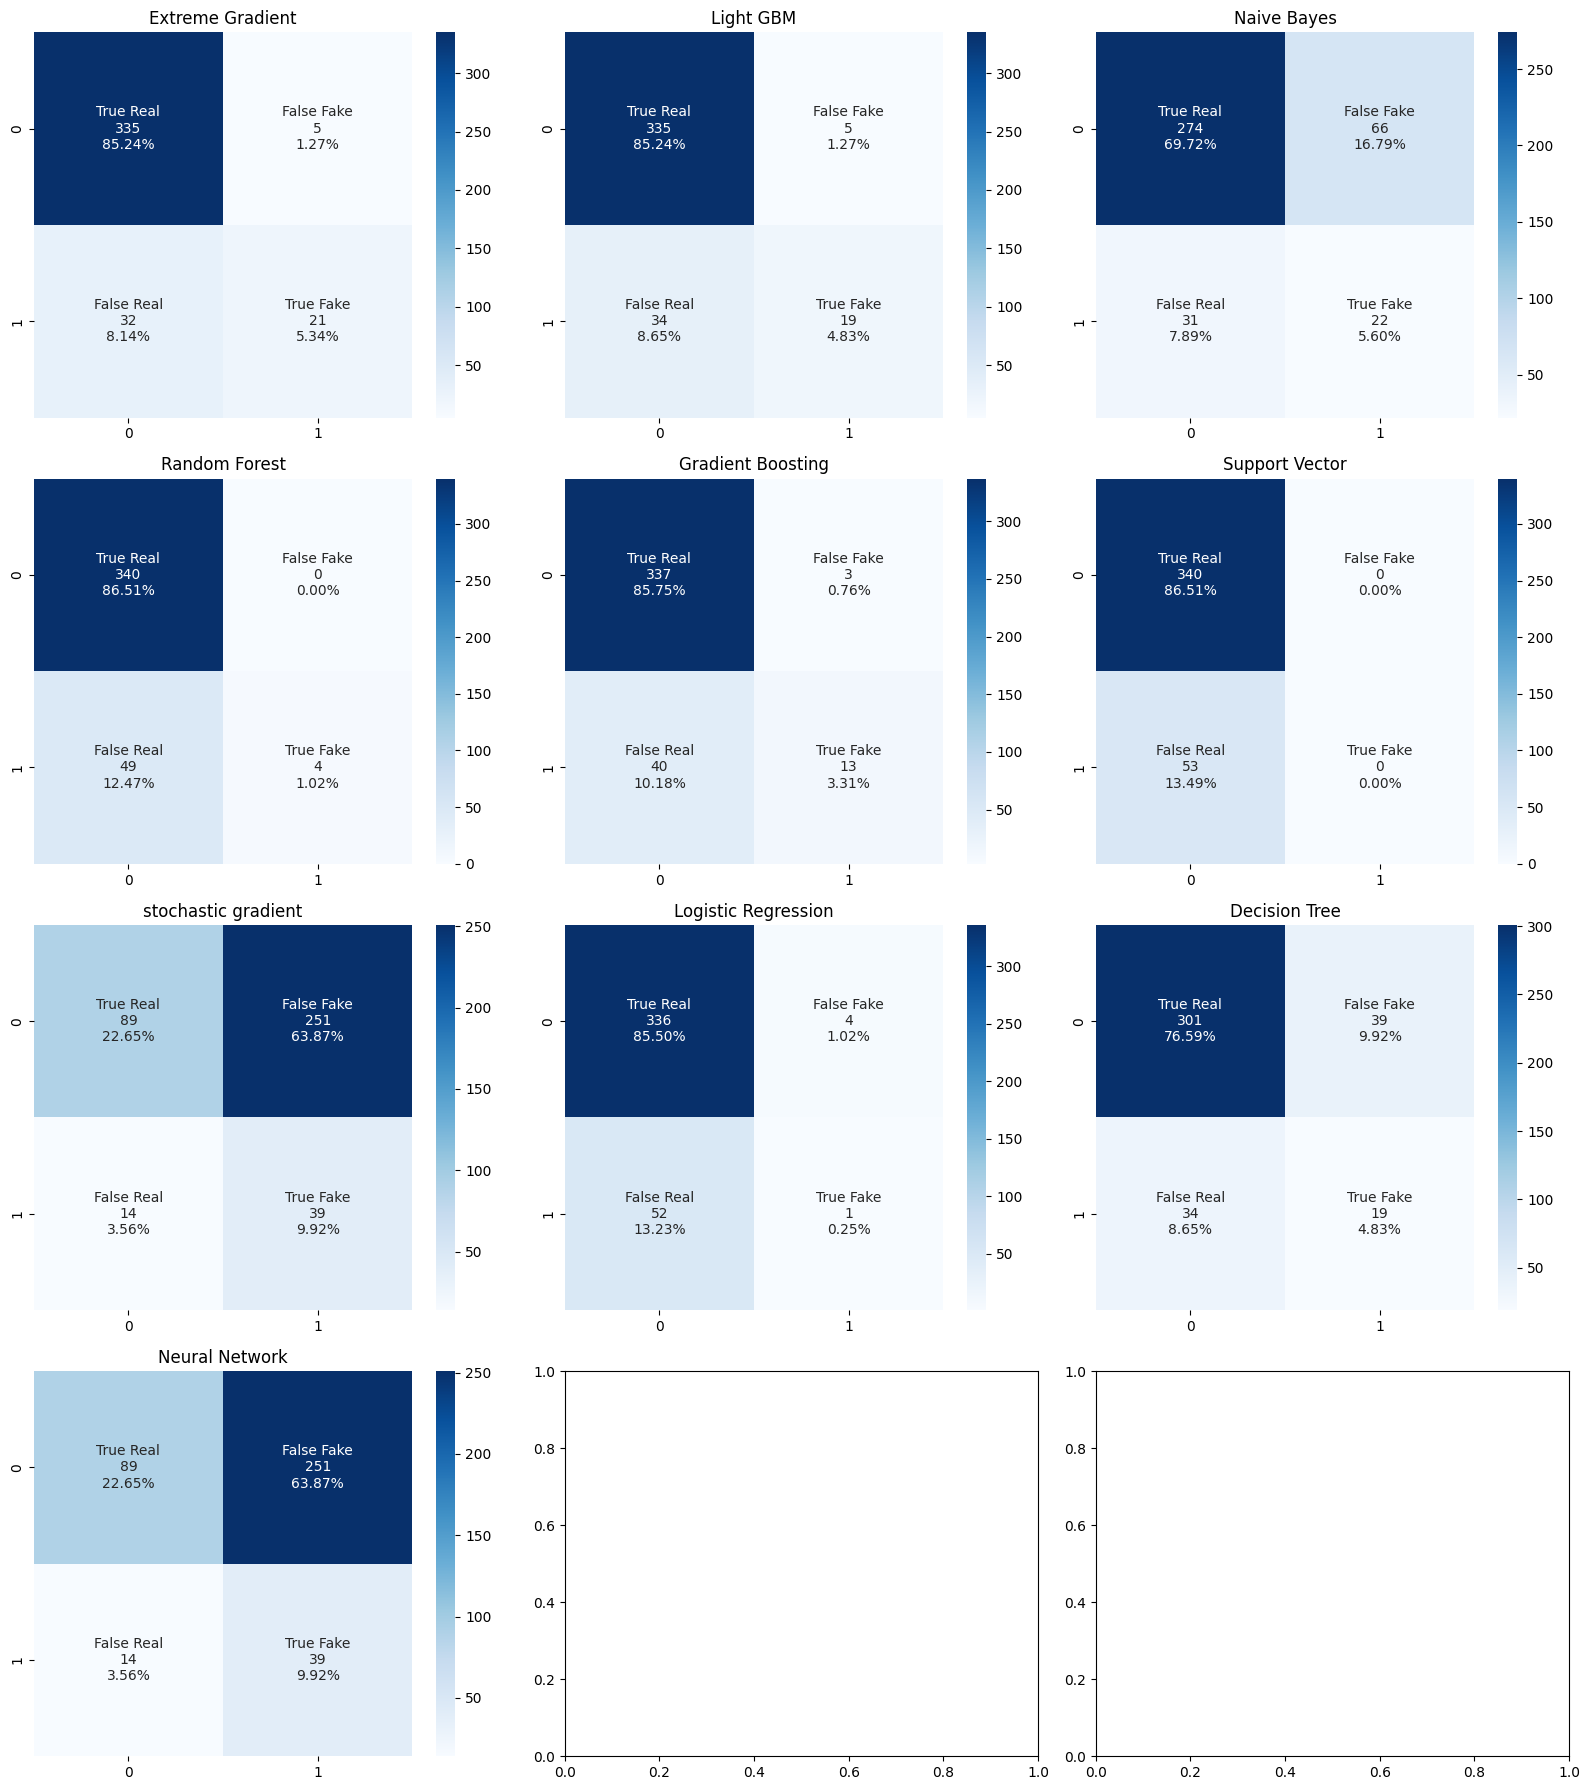

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
fig, axes = plt.subplots(4, 3, figsize=(16, 18))

def plot_grouped_cm(Y, predicted, r,c, model):
  Y_predicted_classes = []
  for x in predicted:
    if x>=0.5:
        Y_predicted_classes.append(1)

    else:
        Y_predicted_classes.append(0)
#  print(len(Y), len(Y_predicted_classes))
  cf_matrix = confusion_matrix(Y,Y_predicted_classes)

  group_names = ['True Real','False Fake','False Real','True Fake']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  print(labels.shape)
  print(cf_matrix.shape)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax =axes[r,c])
  axes[r,c].set_title(model)
xg_acc, lgb_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc, lr_acc, dt_acc, ann_acc
plot_grouped_cm(y_test, pred_xg, 0,0, 'Extreme Gradient')
plot_grouped_cm(y_test, pred_lg, 0,1, 'Light GBM')
plot_grouped_cm(y_test, pred_nb, 0,2, 'Naive Bayes')
plot_grouped_cm(y_test, pred_rf, 1,0, 'Random Forest')
plot_grouped_cm(y_test, pred_gb, 1,1, 'Gradient Boosting')

plot_grouped_cm(y_test, pred_svc, 1,2, 'Support Vector')
plot_grouped_cm(y_test, pred_sg, 2,0, 'stochastic gradient')
plot_grouped_cm(y_test, pred_lr, 2,1, 'Logistic Regression')
plot_grouped_cm(y_test, pred_dt, 2,2, 'Decision Tree')
plot_grouped_cm(y_test, pred_ann, 3,0, 'Neural Network')



fig.tight_layout()
fig.savefig("paper/expsettingI_updated90.png")